# Ground-State Variational Search with NetKet for a Bosonic Matrix Model

September 1, 2021 

In this Tutorial we will use the open-source package [NetKet](https://www.netket.org/) to find the ground state (in a variational sense) of a quantum mechanical system of matrices.
This system is referred to as a bosonic matrix model and was studied in [this preprint](https://arxiv.org/abs/2108.02942). 

Specifically, we will study the system defined by the Hamiltonian: 

$$ \hat{H} = {\rm Tr}\left(\frac{1}{2}\hat{P}_I^2+\frac{m^2}{2}\hat{X}_I^2-\frac{g^2}{4}[\hat{X}_I,\hat{X}_J]^2\right) $$

where 
$$\hat{P}_I=\sum_{\alpha=1}^{N^2-1}\hat{P}_I^\alpha\tau_\alpha$$

and

$$\hat{X}_I=\sum_{\alpha=1}^{N^2-1}\hat{X}_I^\alpha\tau_\alpha$$

for a SU(N) gauge group with $N^2-1$ generators.

## 0. Installing Netket 

Installing NetKet is relatively straightforward. For this Tutorial, if you are running it locally on your machine, we recommend that you create a clean virtual environment (e.g. with `conda`) and install NetKet within (using `pip`): 

```bash
conda create --name netket python pip ipython
conda activate netket
pip install --upgrade netket
```

**If you are on Google Colab**, run the following cell to install the required packages.

In [ ]:
#!pip install --upgrade netket

You can check that the installation was succesfull doing 

In [1]:
import netket as nk

You should also check that your version of netket is at least 3.0

In [2]:
print(f"NetKet version: {nk.__version__}")

NetKet version: 3.0.3


In [3]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Defining The Hamiltonian

The first step in our journey consists in defining the Hamiltonian we are interested in. 
For this purpose, we first need to define the kind of degrees of freedom we are dealing with (i.e. if we have spins, bosons, fermions etc). This is done specifying the Hilbert space of the problem.

For our problem we focus on the gauge group SU(2), which will determine the total number of bosons to be $N^2-1 = 3$ for each matrix. We will focus on 2 matrices, for a total of 6 bosonic degrees of freedom.

We also need to decide a cutoff for the Fock space of each boson $\Lambda$.

### 1.1 The Hilbert space

In [4]:
Lambda = 4  # cutoff of each bosonic Fock space
N = 6  # number of bosons 

hi = nk.hilbert.Fock(n_max=Lambda-1, N=N)  # n_max -> Maximum occupation for a site (inclusive)

Test if the space is constructed as we expected.
We want each of the $N$ bosons to have up to $\Lambda$ excitations: the total Hilbert space is the tensor product of $N$ individual Fock spaces of dimension $\Lambda$ for a total size of $\Lambda^N = 4^6 = 4096$.

In [5]:
# The size of the hilbert space on every site.
hi.shape

(4, 4, 4, 4, 4, 4)

In [6]:
# The total number number of degrees of freedom.
hi.size

6

In [7]:
# The total dimension of the many-body Hilbert space
hi.n_states

4096

We have checked that all the dimensions correspond to our expectations. We can think of this as the Hilbert state of a mnay-body system with $N$ sites of bosons, each with excitations up to level $\Lambda$ (inclusive, starting from 0 to $\Lambda-1$).

### 1.2 The free Hamiltonian

We now need to specify the Hamiltonian.
We will use some predefined operators for bosons, such as the `create` and `destroy` operators for each boson in the Hilber state (see the API documentation [here](https://www.netket.org/docs/api.html#pre-defined-operators)).

In this specifc case, $\hat{a}^\dagger_I$ for each boson $I$ (we can regard this index as a _site_ index in `netket`).



In [8]:
from netket.operator.boson import create, destroy

We now start by defining the free part of the Hamiltonian, which is just a collection of harmonic oscillators


In [9]:
# we loop over all "sites" -> loop over N bosons
H_free = sum([0.5+create(hi,i)*destroy(hi,i) for i in range(N)])

Here we have used a list comprehension to (mildly) show off our ability to write one-liners, however you could have just added the terms one by one in an explicit loop instead (though you'd end up with a whopping 3 lines of code). 

We have also used the fact that NetKet automatically recognizes products of local operators as tensor products and the addition of scalars as if they were multiplied by the identity matrix in the tensor space.

In general, when manipulating NetKet objects, you should always assume that you can safely operate on them like 
you would in mathematical equations, therefore you can sum and multiply them with ease.

### 1.3 Exact Diagonalization

Let us check this free Hamiltonian, whose eigenvectors are analytically known: the ground state has vacuum energy for $N$ independent harmonic oscillators: $0.5N = 0.5 \cdot 6 = 3$ 

In `netket` we can  convert our Hamiltonian operator into a sparse matrix of size $ $\Lambda^N \times \Lambda^N $. 

In [10]:
sp_h=H_free.to_sparse()
sp_h.shape

(4096, 4096)

Since this is just a regular scipy sparse matrix, we can just use any sparse diagonalization routine in there to find the eigenstates. For example, this will find the two lowest eigenstates  

In [11]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k=7, which="SA")

print(f"Eigenvalues with scipy.sparse.linalg.eigsh: {eig_vals}")


Eigenvalues with scipy.sparse.linalg.eigsh: [3. 4. 4. 4. 4. 4. 4.]


These are the expected eigenvalues with the correct degeneracy: the first excited state is repeated $N$ times, and so forth.

*Note*: `netket` also provide a wrapper for `eigsh` in the form of a Lanczos [exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.lanczos_ed.html#netket.exact.lanczos_ed).

In [12]:
eig_vals = nk.exact.lanczos_ed(H_free, k=13, compute_eigenvectors=False)  # args to scipy.sparse.linalg.eighs like can be passed with scipy_args={'tol':1e-8}
print(f"Eigenvalues with exact lanczos (sparse): {eig_vals}")

Eigenvalues with exact lanczos (sparse): [3. 4. 4. 4. 4. 4. 4. 5. 5. 5. 5. 5. 5.]


*Note*: a full (dense) exact diagonalization can also be done for small systems using [this exact solver](https://www.netket.org/docs/_generated/exact/netket.exact.full_ed.html#netket.exact.full_ed)

In [13]:
eig_vals = nk.exact.full_ed(H_free, compute_eigenvectors=False)
print(f"Eigenvalues with exact diag (dense): {eig_vals}\nNumber of eigs: {eig_vals.shape[0]}")

Eigenvalues with exact diag (dense): [ 3.  4.  4. ... 20. 20. 21.]
Number of eigs: 4096


### 1.4 The interaction Hamiltonian

We can now continue building our full Hamiltonian by writing the interaction term.
It is convenient to write the interaction using the `position` operators built from the creation and annihilation bosonic operators

$$\hat{x}_I = \frac{1}{\sqrt{2}} \left( \hat{a}^\dagger_I + \hat{a}_I \right)$$


In [10]:
x_list = [(1 / np.sqrt(2))*(create(hi,i)+destroy(hi,i)) for i in range(N)]

The interactoin terms can be written using the Levi-Civita completely antisymmetric tensor with 3 indices or by writing out all the terms by hand:

In [11]:
### Quartic Interaction for bosons
V_b = (
    x_list[2] * x_list[2] * x_list[3] * x_list[3]
    + x_list[2] * x_list[2] * x_list[4] * x_list[4]
    + x_list[1] * x_list[1] * x_list[3] * x_list[3]
    + x_list[1] * x_list[1] * x_list[5] * x_list[5]
    + x_list[0] * x_list[0] * x_list[4] * x_list[4]
    + x_list[0] * x_list[0] * x_list[5] * x_list[5]
    - 2 * x_list[0] * x_list[2] * x_list[3] * x_list[5]
    - 2 * x_list[0] * x_list[1] * x_list[3] * x_list[4]
    - 2 * x_list[1] * x_list[2] * x_list[4] * x_list[5]
)

And the full Hamiltonian with 't Hooft coupling $\lambda = g^2 N_g$ (where $N_g$ is the gauge group number of colors) is

In [12]:
g2N = 0.2  # 't Hooft coupling lambda
H = H_free + (g2N / 2) * V_b

## 2. Exact Diagonalization

We can repeat for the full Hamiltonian at fixed gauge coupling $g^2N_g$ the exact diagonalization procedure we have used on the free Hamiltonian.

When the gauge coupling constant is small, the difference of the energy of the ground state with the free case $g=0$ will be small.

In [13]:
w = nk.exact.full_ed(H, compute_eigenvectors=False)
print(f"Eigenvalues with exact diag (dense): {w}\nNumber of eigs: {w.shape[0]}")

Eigenvalues with exact diag (dense): [ 3.13406307  4.21516634  4.21516634 ... 22.94954115 22.94954115
 23.42952917]
Number of eigs: 4096


Or we can use the Lanczos solver and only approximately retrieve the lowest $k$ eigenvalues (this is much much quicker)

In [55]:
eig_vals, eig_vecs = nk.exact.lanczos_ed(H, k=4, compute_eigenvectors=True, scipy_args={'tol':1e-8})
print(f"Eigenvalues with exact lanczos (sparse): {eig_vals}")

Eigenvalues with exact lanczos (sparse): [3.13406307 4.21516634 4.21516634 4.21516634]


We can have a look at the ground state eigenvector

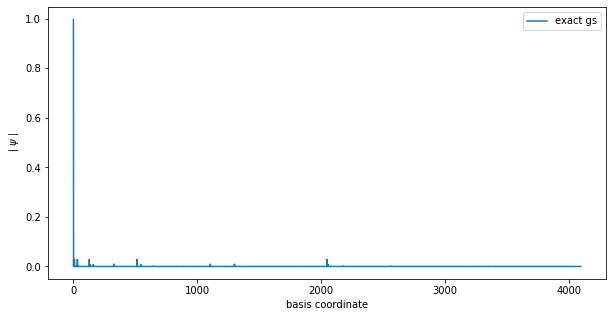

In [85]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.abs(eig_vecs[:,0]),label="exact gs")
ax.set_xlabel("basis coordinate")
ax.set_ylabel(r"$\mid \psi \mid$")
ax.legend(loc=0)

## 3. Mean-Field Ansatz

We now would like to find a variational approximation of the ground state of this Hamiltonian. As a first step, we can try to use a very simple mean field ansatz: 

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \Pi_{i=1}^{N} \Phi(X_i), $$

where the variational parameters are individual boson's wave functions $\Phi(X_i)$. This is probably a bad ansatz, but it will show how the variational Monte Carlo procedure works in `netket`

We can further write $ \Phi(X) = \sqrt{P(X)}e^{i \phi(X)}$.

In order to simplify the presentation, we take here and in the following examples the phase $\phi=0$.

For the normalized single-boson probability we will take a sigmoid form: 

$$P(X; \gamma) = 1/(1 + e^{-\gamma X})$$
thus depending on the real-valued variational parameter $\gamma$. 

In `netket` one has to define a variational function approximating the **logarithm** of the wave-function amplitudes (or density-matrix values).

$$ \langle X_1,\dots X_N| \Psi_{\mathrm{mf}} \rangle = \exp{(\textrm{Model}(X; \theta))} $$

where $\theta$ is a set of parameters.

In this case, the parameter of the model will be just one: $\gamma$.

The Model can be defined using one of the several functional jax frameworks such as Jax/Stax, Flax or Haiku. NetKet includes several pre-built models and layers built with Flax, so we will be using it for the rest of the notebook.

In [15]:
# numerical operations in the model should always use jax.numpy 
# instead of numpy because jax supports computing derivatives. 
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax
import flax
# we refer to `flax.linen` as `nn`. It's a repository of 
# layers, initializers and nonlinear functions.
import flax.linen as nn

# A Flax model must be a class subclassing `nn.Module`
class MF(nn.Module):
    
    # The most compact way to define the model is this.
    # The __call__(self, x) function should take as 
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    @nn.compact
    def __call__(self, x):
        
        # A tensor of variational parameters is defined by calling
        # the method `self.param` where the arguments will be:
        # - arbitrary name used to refer to this set of parameters
        # - an initializer used to provide the initial values. 
        # - The shape of the tensor
        # - The dtype of the tensor.
        gam = self.param(
            "gamma", nn.initializers.normal(), (1,), float
        )
        
        # compute the probabilities
        p = nn.log_sigmoid(gam*x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

### 3.1 Variational State

The model itself is only a set of instructions on how to initialise the parameters and how to compute the result. 

To actually create a **variational state** with its parameters, the easiest way is to construct a Monte-Carlo-sampled Variational State. 

To do this, we first need to define a sampler.

In [`netket.sampler`](https://www.netket.org/docs/api.html#list-of-samplers) several samplers are defined, each with its own peculiarities.

In the following example, we will be using a simple sampler that chooses the occupation number of each boson at random (uniform between 0 and $\Lambda-1$) one by one.

You can read more about how the sampler works by checking the documentation with `?nk.sampler.MetropolisLocal`

In [18]:
# Create an instance of the model.
# Notice that this does not create the parameters.
mf_model = MF()

# Create the local sampler on the hilbert space (by default is uses 16 chains)
sampler = nk.sampler.MetropolisLocal(hi, n_chains=8)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=500)


In [19]:
vstate.sampler

MetropolisSampler(
  hilbert = Fock(n_max=3, N=6),
  rule = LocalRule(),
  n_chains = 8,
  machine_power = 2,
  reset_chains = False,
  n_sweeps = 6,
  dtype = <class 'numpy.float64'>)

You can play around with the variational state: for example, you can compute expectation values yourself or inspect it's parameters

In [20]:
# you can inspect the parameters which contain the single
# variational parameter `gamma`
print(vstate.parameters)

FrozenDict({
    gamma: DeviceArray([0.00645872], dtype=float64),
})


In [22]:
# Expectation value: notice that it also provides an error estimate.
print(vstate.expect(H))

12.91 ± 0.14 [σ²=9.76, R̂=1.0028]


The last cell was run with a randomly initialized parameter $\gamma$ and for 500 samples (notice the metrics for the convergence of the Monte Carlo algorithm in square brackets). The output is $<O>= <\Psi|O|\Psi>/<\Psi|\Psi>$ for $O=\hat{H}$

## 4. Variational Monte Carlo

We will now try to optimise $ \gamma $ in order to best approximate the ground state of the hamiltonian.

To do so, first I need to pick an iterative optimiser. We choose stochastic gradient descent with a learning
rate of $0.05$.
Then, we must provide all the elements to the variational monte carlo driver, which takes case of setting up and running the whole optimisation.

For example, the driver can be run for a specific number of iterations. Each iteration will have to run the Monte Carlo sampling defined by the variational state `nk.vqs.MCState`.

In [23]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

# expectation value of the energy
mf_energy = vstate.expect(H)
# compare with the Lanczos exact diagonalization energy eigenvalue
error = abs((mf_energy.mean - eig_vals[0]) / eig_vals[0])



No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████| 300/300 [00:08<00:00, 35.39it/s, Energy=3.347 ± 0.020 [σ²=0.195, R̂=1.0347]] 


In [24]:
#  we can also inspect the parameter:
print("Final optimized parameter: ", vstate.parameters["gamma"])

Final optimized parameter:  [-4.62971102]


In [25]:
print(f"Final optimized energy relative error (with mean-field ansatz): {error*100:.2f}%")

Final optimized energy relative error (with mean-field ansatz): 5.35%


Even a very rudimentary ansatz without interactions between the degrees of freedom is sufficient to reach a < 10% error on the ground state energy with a single parameter to optimize.

We will see more complicated ansatzë below.

## 5. Jastrow Ansatz

We have seen that the mean field ansatz yields a sub 10% error on the ground-state energy. Let's now try to do better, using a more correlated ansatz. 

We will now take a short-range Jastrow ansatz which is already inlcuded in `netket` as [`nk.models.Jastrow`](https://www.netket.org/docs/_generated/models/netket.models.Jastrow.html#netket.models.Jastrow):

$$\log{\Psi(X)} = \sum_{ij} X_i W_{ij} X_j$$

where $W_{ij}$ is a symmetric matrix of learnable complex parameters (the _kernel_ of the quadratic form).

In [26]:
# change the model: initialize weights with normal distributions
model = nk.models.Jastrow(kernel_init=nn.initializers.normal())

# we use the same MetropolicLocal sapmler as before. Now we sample for longer to get a more accurate result
vstate = nk.vqs.MCState(sampler, model, n_samples=1000)


In [27]:
# number of parameters
vstate.n_parameters

36

In [28]:
# look at the parameters
vstate.parameters

FrozenDict({
    kernel: DeviceArray([[ 0.00263441+6.58641854e-03j,  0.00268316+7.21080864e-03j,
                  -0.0146159 +9.07505448e-03j,  0.00987534+6.61406254e-03j,
                   0.00881946+2.41012656e-03j, -0.00922332+1.25334651e-02j],
                 [ 0.00028552+5.15425719e-03j, -0.00228583+6.30209345e-03j,
                  -0.00385356+4.94457856e-03j, -0.00388155-1.63906097e-02j,
                   0.00768883+1.37295341e-02j,  0.00205311-5.81268937e-03j],
                 [ 0.00925844+1.45320163e-03j,  0.00274515+2.12943163e-03j,
                   0.01783749+5.07647061e-03j,  0.00373303+1.07123940e-02j,
                  -0.00321313-3.53795307e-03j,  0.00347366-2.94830600e-03j],
                 [-0.01737268-3.98879771e-03j,  0.00238721-4.93761871e-03j,
                   0.00189215+1.07495319e-02j, -0.00492633-1.42219989e-03j,
                   0.01163646+1.54089307e-03j, -0.00067164+8.86711797e-03j],
                 [-0.00758896-8.72860291e-03j,  0.00271318+5.30

The sampler runs with a default number of chains (16 in this case) and will produce a total of `n_samples` (1000 in this case), so that we would have individual chains of 1000/16=62.5 (63) samples
If we change the number of chains to 8, than `chain_length` would be 1000/8=125 samples (and each chain would always run a burnin phase of 1000*0.1=100 samples)

In [29]:
vstate.sampler

MetropolisSampler(
  hilbert = Fock(n_max=3, N=6),
  rule = LocalRule(),
  n_chains = 8,
  machine_power = 2,
  reset_chains = False,
  n_sweeps = 6,
  dtype = <class 'numpy.float64'>)

In [30]:
vstate.chain_length

125

We then optimize it, however this time we also introduce a stochastic reconfiguration (natural gradient) preconditioner:

In [31]:
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

preconditioner = nk.optimizer.SR(diag_shift=0.1)

# driver for running the simulation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=preconditioner)

We now log the intermediate results of the optimization, so that we can visualize them at a later stage. 

In [32]:
# Loggers that work together with optimisation drivers are defined in nk.logging.
# RuntimeLog keeps the metrics in memory, JsonLog stores them to a json file which can be read
# as a dict, TensorBoardLog can be used to log to TensorBoard.
log=nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)


100%|██████████| 300/300 [00:07<00:00, 41.48it/s, Energy=3.150e+00+6.415e-08j ± nan [σ²=2.803e-45, R̂=0.9963]]


(<netket.logging.runtime_log.RuntimeLog at 0x7ff3a928d3a0>,)

In [33]:
print(f"Final optimized kernel parameters: {vstate.parameters['kernel']}\n")
jas_energy=vstate.expect(H)
error=abs((jas_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error*100:.2f}%")

Final optimized kernel parameters: [[-1.63709746+2.30962614e-02j -0.06155228+1.28611255e-03j
  -0.08425965-3.54587997e-05j  0.00480241-4.24662616e-03j
  -0.11130501+2.67992586e-03j -0.10255581+1.46657941e-02j]
 [-0.06394993-7.70438908e-04j -1.67739378+1.45305490e-02j
  -0.07727854-1.01637956e-03j -0.12208938-1.64138365e-02j
  -0.01992407+7.60235913e-03j -0.09968757-5.07858504e-03j]
 [-0.06038532-7.65731164e-03j -0.07067983-3.83152649e-03j
  -1.65059983+2.19313923e-02j -0.10241968+1.53718960e-02j
  -0.11137708-1.58294457e-03j -0.02900832-1.18152136e-02j]
 [-0.0224456 -1.48494864e-02j -0.11582062-4.96084545e-03j
  -0.10426056+1.54090339e-02j -1.65131765+5.00486030e-03j
  -0.05622856+4.35056804e-04j -0.05433751+7.36037925e-03j]
 [-0.12771342-8.45880361e-03j -0.02489973-8.27164118e-04j
  -0.10732828+6.42012012e-03j -0.06206022+3.25613683e-03j
  -1.66681493+6.59669289e-03j -0.05737968-7.76316659e-04j]
 [-0.10175582+5.74594501e-03j -0.10049098+7.34707522e-04j
  -0.03814658-8.94699673e-03j -0

You can now see that this ansatz is almost one order of magnitude more accurate than the mean field! 

In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, here we have just used a simple one that stores the intermediate results as values in a dictionary. 

In [34]:
data_jastrow = log.data
print(data_jastrow)

{'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


In [35]:
energy_history = data_jastrow["Energy"].Mean.real
energy_error_history = data_jastrow["Energy"].Sigma.real

These report several intermediate quantities, that can be easily plotted. For example we can plot the value of the energy (with its error bar) at each optimization step.  

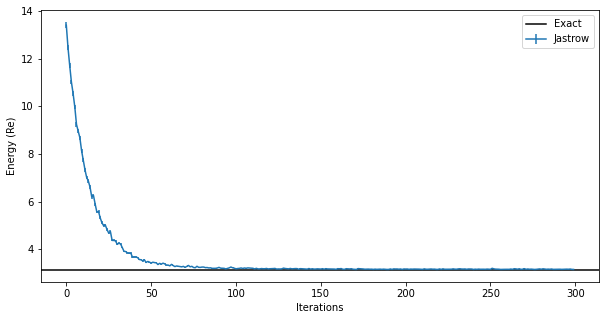

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, energy_history, yerr=energy_error_history, label="Jastrow")
ax.axhline([eig_vals[0]], xmin=0, xmax=300, color='black', label="Exact")
ax.legend()
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)');

You can also look at the MCMC chain properties

Text(0.5, 0, 'Iterations')

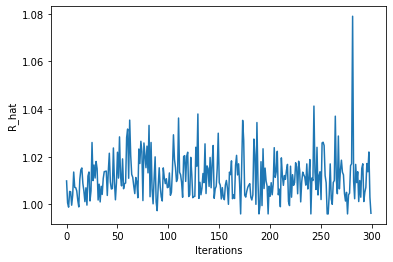

In [37]:
plt.plot(data_jastrow["Energy"].R_hat)
plt.ylabel("R_hat")
plt.xlabel("Iterations")

Some chains have `R_hat` larger than ones, which means they might not have converged within the 1000 samples that we had specified...

* Each variational state can be sampled with an arbitraty number of chains, samples per chain and burnin steps (discarded samples) (see the [sampling](https://www.netket.org/docs/varstate.html#sampling) section of the documentation)
* Each state can be written in the computational basis by calling the `to_array()` method (in this case we have 4096 elements in our basis, so we would get a 4096-dim vector)

In [38]:
vstate.samples.shape  # [chain_length, n_chains, n_sites]

(125, 8, 6)

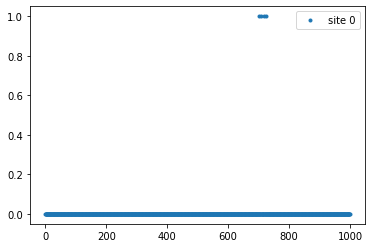

In [39]:
# boson sampling:
plt.plot(vstate.samples[:,:,0].flatten(), '.', label="site 0")
plt.legend()

The variational state, projected onto the computational basis (Fock space in this case) is just peaked onto 0, which would also be the ground state of the free Hamiltonian

In [40]:
vstate.to_array().shape

(4096,)

(0.0, 100.0)

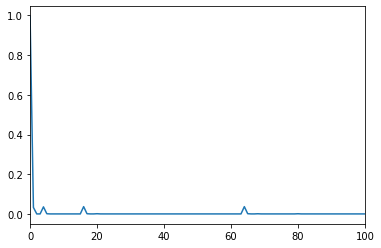

In [41]:
plt.plot(vstate.to_array().real)
plt.xlim([0,100])

## 6. Neural-Network Quantum State 

We now want to use a more sofisticated ansatz, based on a neural network representation of the wave function. At this point, this is quite straightforward, since we can again take advantage of automatic differentiation. 

Let us define a simple fully-connected feed-forward network with a ReLu activation function and a sum layer. 

In [44]:
class FFN(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module. This is the ratio of neurons to input dofs
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer using a
        # pre-built implementation in flax.
        # features is the number of output nodes
        # WARNING: Won't work with complex hamiltonians because
        # of a bug in flax. Use nk.nn.Dense otherwise. 
        dense = nk.nn.Dense(features=self.alpha * x.shape[-1])
        
        # we apply the dense layer to the input
        y = dense(x)

        # the non-linearity is a simple ReLu
        y = nn.relu(y)
        
        # sum the output
        return jnp.sum(y, axis=-1)

In [45]:
# it is easy here to pass the hyper-parameter value
model = FFN(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

*Warning*: Flax has a bug with its layers, where they drop the imaginary part
of complex numbers if the layer has real weights.
If you try to work on more complex
problems where you work with complex numbers you should rather use the equivalent 
`nk.nn.Dense` which contains a fix for this bug.

Define a callback to keep track of the acceptance for each sampling process

In [46]:
def acc_cb(step, logged_data, driver):
        logged_data["acceptance"] = float(driver.state.sampler_state.acceptance)
        return True

We then proceed to the optimization as before. 

In [47]:
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

# logging and running
log = nk.logging.RuntimeLog()
gs.run(n_iter=3000, out=log, callback=acc_cb)


100%|██████████| 3000/3000 [00:41<00:00, 72.61it/s, Energy=3.151e+00 ± 9.657e-18 [σ²=1.972e-31, R̂=0.9987]] 


(<netket.logging.runtime_log.RuntimeLog at 0x7ff3a928d130>,)

In [48]:
ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - eig_vals[0]) / eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")


Optimized energy: 3.151e+00 ± 9.657e-18 [σ²=1.972e-31, R̂=0.9987] 
Relative error: 0.53%


The variance of the final answer is zero, indicating a possibly troublesome sampling. We can investigate by looking at the samples themselves and see that the sampling is stuck in one state and not ergodic

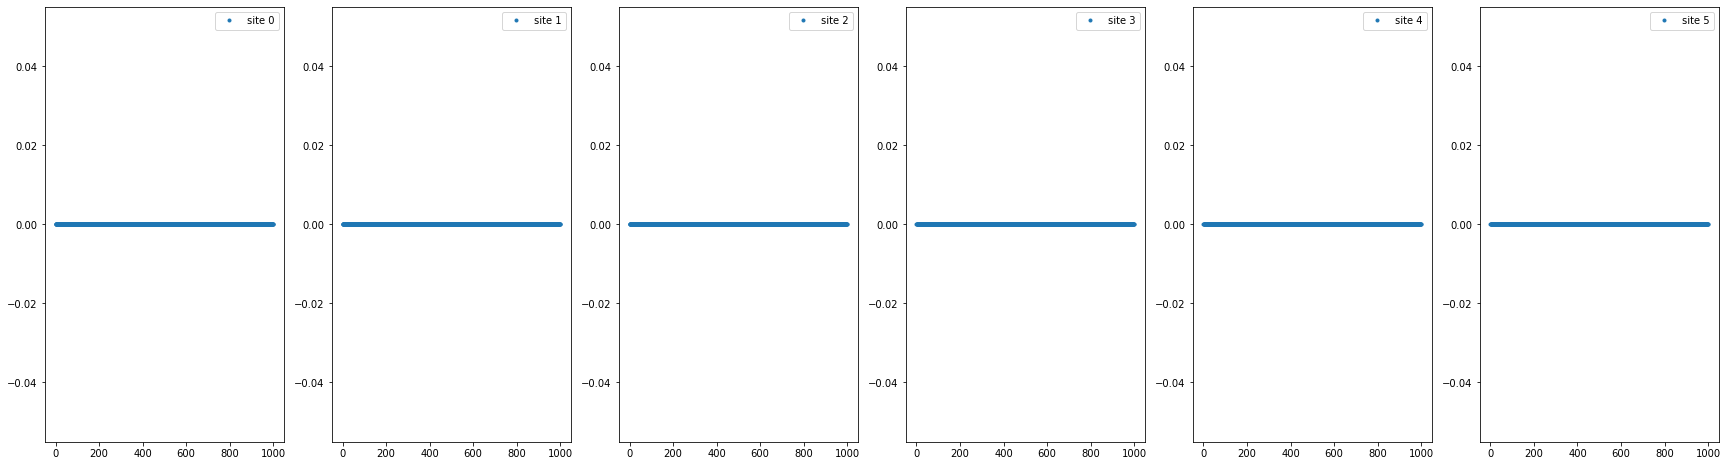

In [49]:
fig, ax = plt.subplots(ncols=N,figsize=(30,8))
for i,axi in enumerate(ax):
    axi.plot(vstate.samples[:,:,i].flatten(), '.', label=f"site {i}")
    axi.legend()

The variational ground state can be compared to the exact state (from exact diagonalization)

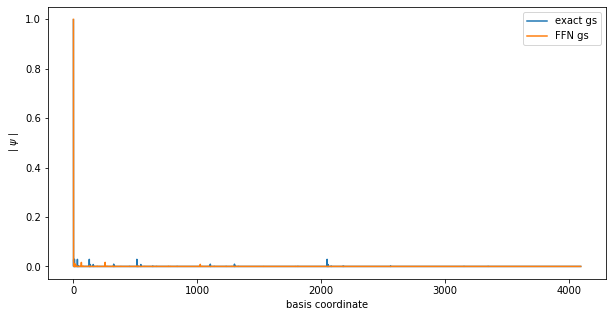

In [93]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(np.abs(eig_vecs[:,0]),label="exact gs")
ax.plot(np.abs(vstate.to_array()),label="FFN gs")
ax.set_xlabel("basis coordinate")
ax.set_ylabel(r"$\mid \psi \mid$")
ax.legend(loc=0)

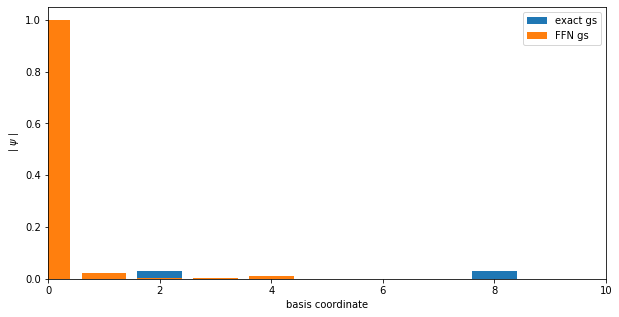

In [117]:
fig, ax = plt.subplots(figsize=(10,5))
ax.bar(np.arange(0,hi.n_states),np.abs(eig_vecs[:,0]),label="exact gs")
ax.bar(np.arange(0,hi.n_states),np.abs(vstate.to_array()),label="FFN gs")
ax.set_xlim([0,10])
ax.set_xlabel("basis coordinate")
ax.set_ylabel(r"$\mid \psi \mid$")
ax.legend(loc=0)

In [125]:
print(f"Exact gs (0): {eig_vecs[0,0]}\nFFN gs (0): {vstate.to_array()[0]}")

Exact gs (0): -0.9972064669940288
FFN gs (0): 0.9992466939765233


And we can compare the results between the two different ansatze:

Text(0, 0.5, 'Energy (Re)')

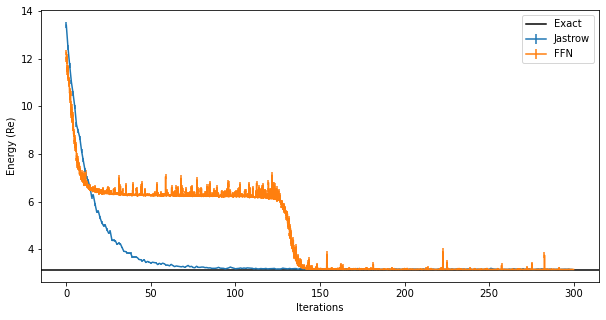

In [51]:
data_FFN = log.data

fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_jastrow["Energy"].iters, data_jastrow["Energy"].Mean.real, yerr=data_jastrow["Energy"].Sigma, label="Jastrow")
ax.errorbar(data_FFN["Energy"].iters/10, data_FFN["Energy"].Mean.real, yerr=data_FFN["Energy"].Sigma, label="FFN")
ax.axhline([eig_vals[0]], xmin=0, xmax=300, color='black', label="Exact")
ax.legend()

ax.set_xlabel('Iterations')
ax.set_ylabel('Energy (Re)')

We used a callback to save the acceptance rate. We can plot it now

Text(0, 0.5, 'Acc. Rate')

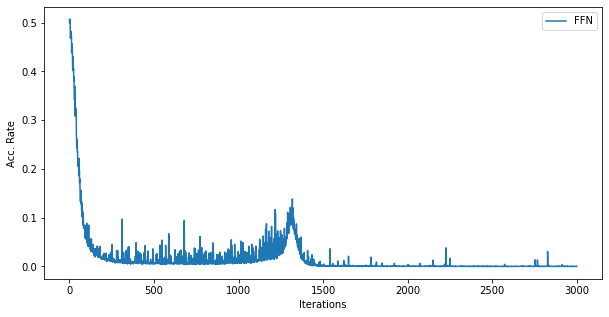

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(data_FFN["Energy"].iters, data_FFN["acceptance"]["value"], label="FFN")
ax.legend()

ax.set_xlabel('Iterations')
ax.set_ylabel('Acc. Rate')

### 6.1 Increasing the features

We can try to use more _neurons_ in the dense layer to see if we can get a better result.
This can be done simply by instantiating the `FFN` model again with a larger `alpha`.

In [38]:
# it is easy here to pass the hyper-parameter value
model = FFN(alpha=2)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate,preconditioner=nk.optimizer.SR(diag_shift=0.1))
gs.run(n_iter=600)

ffn_energy=vstate.expect(H)
error=abs((ffn_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {ffn_energy} \nRelative error: {error*100:.2f}%")

No output specified (out=[apath|nk.logging.JsonLogger(...)]).Running the optimization but not saving the output.


100%|██████████| 300/300 [00:13<00:00, 22.02it/s, Energy=6.250e+00 ± 1.958e-16 [σ²=3.865e-29, R̂=1.0121]]


Optimized energy: 6.2526 ± 0.0015 [σ²=0.0024, R̂=1.0069] 
Relative error: 99.50%


This is the best we can do without taking into consideration the phase of the wave function.

## 7. Learning the Phase of the Wave Function

In the examples shown before we have ignored completely the phase of the wave function. For the ground state of this bosonic matrix model, the phase is not stricly needed.

Training models with a phase is significantly less trivial than optimizing phaseless models, thus we will adopt here a heuristic approximation approach that has proven quite robust.
What we will do here is that we will train the model using different (and time-dependent) learning rates for the phase and modulus parts of the wave function.

The learning schedule rate is chosen in such as way that in the firs stages we will optimize mostly only the phase, while leaving the amplitude more or less constant. The schedule then will ramp up the learning rate for the amplitude and we will optimize everything at the same time. 

We define a fully-connected model that will include a network for the modulus and a network for the phase. Remember that the models are the logarithm of the density function $\Psi(X)$ (so the phase network will appear with an imaginary unit and will be summed to the log of the modulus)

In [46]:
class FFNPhase(nn.Module):
    
    # You can define attributes at the module-level
    # with a default. This allows you to easily change
    # some hyper-parameter without redefining the whole 
    # flax module. This is the ratio of neurons to input dofs
    alpha : int = 1
            
    @nn.compact
    def __call__(self, x):

        # here we construct the first dense layer for the modulus rho
        dense_m = nk.nn.Dense(features=self.alpha * x.shape[-1], dtype=float, name="Modulus")
        # we apply the dense layer to the input
        rho = dense_m(x)
        # the non-linearity is a simple ReLu
        rho = nn.relu(rho)

        # repeat now for the phase
        dense_p = nk.nn.Dense(features=self.alpha * x.shape[-1], dtype=float, name="Phase")
        # we apply the dense layer to the input
        phase = dense_p(x)
        # the non-linearity is a simple ReLu
        phase = nn.relu(phase)
        # sum the output
        return jnp.sum(rho, axis=(-1)) + 1.0j*jnp.sum(phase, axis=(-1))

In [47]:
# it is easy here to pass the hyper-parameter value
model = FFNPhase(alpha=1)

vstate = nk.vqs.MCState(sampler, model, n_samples=1000)

In [48]:
print(f"Number of parameters: {vstate.n_parameters}")

Number of parameters: 84


We then proceed to the optimization of the phase only. This is achieved the scheduling functionalities of  ```optax```, the optimization library that is fully compatible with `netket`. Notice that here we start with zero learning rate for the modulus and finite learning rate for the phase. 

In [49]:
import optax,flax

total_steps = 1000

# A linear schedule varies the learning rate from 0 to 0.01 across n steps.
modulus_schedule=optax.linear_schedule(0,0.01,total_steps)

# The phase starts with a larger learning rate and then is decreased.
phase_schedule=optax.linear_schedule(0.1,0.01,total_steps)

# Combine the linear schedule with SGD
optm=optax.sgd(modulus_schedule)
optp=optax.sgd(phase_schedule)

# The multi-transform optimizer uses different optimisers for different parts of the
# parameters.
optimizer = optax.multi_transform({'o1': optm, 'o2': optp}, 
                flax.core.freeze({"Modulus":"o1", "Phase":"o2"}))

This new optimizer can then be used as before in the MC driver:

In [51]:
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1)
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=total_steps, out=log)

100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s, Energy=3.1766-0.0002j ± 0.0055 [σ²=0.0301, R̂=1.0261]]


(<netket.logging.runtime_log.RuntimeLog at 0x12ee0a1f0>,)

In [52]:
ffnp_energy=vstate.expect(H)
error=abs((ffnp_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {ffnp_energy} \nRelative error: {error*100:.2f}%")

Optimized energy: 3.1549-0.0001j ± 0.0026 [σ²=0.0071, R̂=1.0363] 
Relative error: 0.66%


Adding a phase does not seem to change the answer significantly, as we expected

## 8. Autoregressive models

In [this paper](https://arxiv.org/abs/2108.02942), an autoregressive flow model was used to parametrize the modulus of the wave function, while a fully-connected layer was used for the phase.
The paper worked in a basis of coordinates for the matrices $X_I$ which is different from the basis of the Fock space we have chosen in this example.
We do not expect to get the same results.

Autoregressive models are included in `netket`, together with direct samplers for their conditional distributions (see [this link](https://www.netket.org/docs/_generated/models/netket.models.ARNNDense.html#netket-models-arnndense) for a fully-connected autoregressive model)

In [58]:
model = nk.models.ARNNDense(hilbert=hi, layers=3, features=10)

# the autoregressive model has an exact sampler because of the conditional prob
sampler = nk.sampler.ARDirectSampler(hi)

# With direct sampling, we don't need many samples in each step to form a
# Markov chain, and we don't need to discard samples
vstate = nk.vqs.MCState(sampler, model, n_samples=64)

In [54]:
print(f"Number of parameters (ARNNDense): {vstate.n_parameters}")

Number of parameters (ARNNDense): 5544


Then we can call our driver as before

In [61]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(H, optimizer, variational_state=vstate, preconditioner=preconditioner)

# logging and running
log=nk.logging.RuntimeLog()
gs.run(n_iter=1000,out=log)

arnn_energy=vstate.expect(H)
error=abs((arnn_energy.mean-eig_vals[0])/eig_vals[0])
print(f"Optimized energy: {arnn_energy} \nRelative error: {error*100:.2f}%")

100%|██████████| 1000/1000 [03:04<00:00,  5.43it/s, Energy=3.150e+00 ± 9.791e-17 [σ²=9.664e-30, R̂=1.0056]]


Optimized energy: 3.150e+00 ± 9.791e-17 [σ²=9.664e-30, R̂=1.0056] 
Relative error: 0.51%


## 9. Measuring Other Properties

Once the model has been optimized, we can of course measure also other observables that are not the energy. For example, we could measure the generators of the gauge transformations.

We could also use a larger number of samples to have a sufficiently low error bar on their measurement, by changing `vstate.n_samples` on the fly.

The Casimir operator for the gauge group is defined using a combination of $\hat{a}^\dagger_I$ and $\hat{a}_I$ for each boson. We are assuming that sites 0, 1, and 2 are for the 3 gauge dof of one matrix and site 3, 4, and 5 are for the other matrix. Given this assignment we can write

$$ \hat{G}_{\alpha}=i \sum_{\beta, \gamma, I} f_{\alpha \beta \gamma} \hat{a}_{I \beta}^{\dagger} \hat{a}_{I \gamma} $$

In [56]:
g_list = [0] * 3
g_list[0] = 1j * (
    create(hi,1) * destroy(hi,2)
    - create(hi,2) * destroy(hi,1)
    + create(hi,4) * destroy(hi,5)
    - create(hi,5) * destroy(hi,4)
)
g_list[1] = 1j * (
    create(hi,2) * destroy(hi,0)
    - create(hi,0) * destroy(hi,2)
    + create(hi,5) * destroy(hi,3)
    - create(hi,3) * destroy(hi,5)
)
g_list[2] = 1j * (
    create(hi,0) * destroy(hi,1)
    - create(hi,1) * destroy(hi,0)
    + create(hi,3) * destroy(hi,4)
    - create(hi,4) * destroy(hi,3)
)
G = sum([g * g for g in g_list])

We can sample 1000 times to get a more accurate result. We expect to find zero if the ground state is gauge invariant

In [62]:
vstate.n_samples = 1000
vstate.expect(G)

0.000e+00+0.000e+00j ± nan [σ²=0.000e+00]